## Speedtest for torch and numpy

This notebook is a simple speedtest to investigate what produces the runtime overhead in PyTorch optimizations.

In [156]:
import torch
import time
import scipy.optimize
import numpy as np
from typing import Tuple
import pandas as pd
from pathlib import Path

from cblearn.embedding._torch_utils import assert_torch_is_available, torch_minimize
sns.set_theme("paper", "whitegrid", font_scale=1.5)
plot_dir = Path('../plots')
plot_dir.mkdir(exist_ok=True)


def f_numpy(x: np.ndarray, A: np.ndarray, y: np.ndarray) -> Tuple[float, np.ndarray]:
    losses = (y - A@x)**2
    loss = losses.sum()
    grad = -2 * A.T @ (y - A@x)

    return loss, grad

def f_numpy_internaltorch(x: np.ndarray, A: np.ndarray, y: np.ndarray) -> Tuple[float, np.ndarray]:
    A2 = torch.from_numpy(A)
    y2 = torch.from_numpy(y)

    x2 = torch.from_numpy(x)
    x2.requires_grad = True

    losses = (y2 - A2@x2)**2
    loss = losses.sum()
    loss.backward()

    return loss.item(), x2.grad.detach().numpy()


def f_torch(x: torch.Tensor, A: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    losses = (y - A@x)**2
    loss = losses.sum()

    return loss


def optimize(optim, f, lr=0.1, max_iter=1000, *args):
    n = 200  # n observations
    d = 100  # d features
    A = np.random.uniform(low=-1, high=1, size=(n, d))
    x_star = np.random.uniform(low=0, high=1, size=d)
    y = A @ x_star

    x0 = np.random.uniform(low=-0.1, high=0.1, size=d)

    if optim == 'scipy':
        result = scipy.optimize.minimize(
            f,
            x0=x0,
            args=(A, y),
            jac=True,
            method="L-BFGS-B",
        )
    elif optim == 'torch':
        result = torch_minimize('adam', f, x0, data=(A, y),
                                device='CPU', max_iter=max_iter, lr=lr)

    if not result.success:
        print(f"optimization failed: {result.message}.\n")
    norm = np.linalg.norm
    rel_error = norm(result.x - x_star) / norm(x_star)
    return rel_error


def measure_time(n_repeat: int, func, **args):
    timings = []
    responses = []
    for _ in range(n_repeat):
        start_time = time.process_time()
        resp = func(**args)
        end_time = time.process_time()
        timings.append(end_time - start_time)
        responses.append(resp)

    return timings, responses

n = 50
total_df = pd.DataFrame()
np.random.seed(42)
times, responses = measure_time(n, optimize, optim='scipy', f=f_numpy)
df = pd.DataFrame({"time": times, "error": responses, "method": "scipy"})
total_df = pd.concat([total_df, df])

times, responses = measure_time(n, optimize, optim='scipy', f=f_numpy_internaltorch)
df = pd.DataFrame({"time": times, "error": responses, "method": "scipy+autograd"})
total_df = pd.concat([total_df, df])

times, responses = measure_time(n, optimize, optim='torch', f=f_torch, lr=0.05)
df = pd.DataFrame({"time": times, "error": responses, "method": "torch"})
total_df = pd.concat([total_df, df])


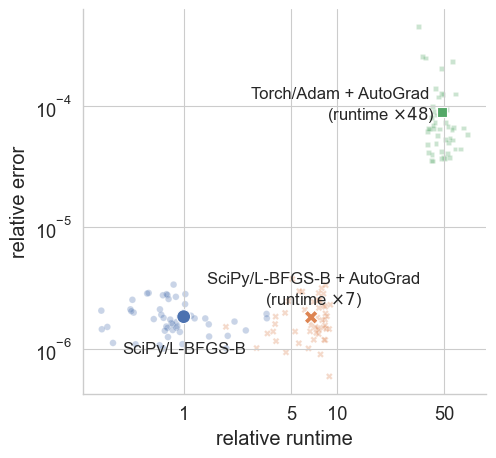

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

total_df['rel_time'] = total_df['time'] / total_df[total_df.method=='scipy']['time'].mean()
mean_df = total_df.groupby('method').mean().reset_index()
autograd_cost = mean_df[mean_df.method=='scipy+autograd']['time'].item() / mean_df[mean_df.method=='scipy']['time'].item()
torch_cost = mean_df[mean_df.method=='torch']['time'].item() / mean_df[mean_df.method=='scipy']['time'].item()
p = sns.relplot(kind="scatter", data=mean_df, x="rel_time", y="error",
                hue="method", style='method',
                s=100, legend=False)
sns.scatterplot(data=total_df, x="rel_time", y="error", hue="method", style='method',
                legend=False, alpha=0.3, zorder=0)
plt.text(1, 0.000001, "SciPy/L-BFGS-B", fontsize=12, ha='center', va='center')
plt.text(7, 0.000003, "SciPy/L-BFGS-B + AutoGrad\n"
         f"(runtime $\\times {autograd_cost:.0f}$)", fontsize=12, ha='center', va='center')
plt.text(43, 0.0001, "Torch/Adam + AutoGrad \n"
         f"(runtime $\\times {torch_cost:.0f}$)", fontsize=12, ha='right', va='center')

plt.xscale('log', base=10)
p.set(xticks=[1, 5, 10, 50], xticklabels=[1, 5, 10, 50],
      xlabel="relative runtime", ylabel="relative error")
plt.yscale('log')
plt.savefig(plot_dir / 'torch_speedtest.pdf', bbox_inches='tight')
plt.savefig(plot_dir / 'torch_speedtest.png', bbox_inches='tight')

## Hyperparameters

The performance of the adam optimizer depends largely on the learning rate.
We will therefore test different learning rates to choose the best one, to ensure a fair comparison.

In [62]:
lr_df = pd.DataFrame()
n = 5
np.random.seed(42)
for lr in (0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10):
    print(lr)
    times, responses = measure_time(n, optimize, optim='torch', f=f_torch, lr=lr)
    df = pd.DataFrame({"time": times, "error": responses, "lr": lr})
    lr_df = pd.concat([lr_df, df])


0.001
optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

0.005
optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

0.01
0.05
0.1
0.5
1
optimization failed: adam did not converge..

5
optimization failed: adam did not converge..

optimization failed: adam did not converge..

10
optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..



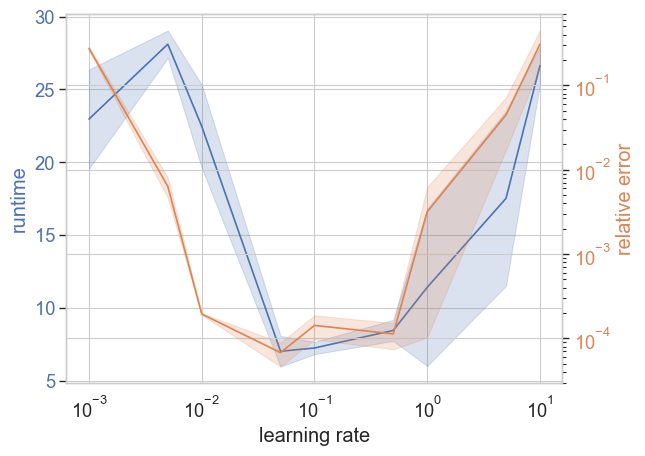

In [170]:
# time and error should both be on the y-axis
# therefore create a long dataframe with a value column, containing either time or error
lr_df_2 = pd.melt(lr_df, id_vars=['lr'], value_vars=['time', 'error'], var_name='metric', value_name='value')


fig, ax1 = plt.subplots()

ax1.set_xlabel('learning rate')
ax1.set_ylabel('runtime', color = 'C0')
#ax1.plot(lr_df['lr'], lr_df['time'], color = 'C0')
sns.lineplot(data=lr_df, x='lr', y='time', color='C0', ax=ax1, errorbar='se')
ax1.tick_params(axis ='y', labelcolor = 'C0')

# Adding Twin Axes

ax2 = ax1.twinx()

ax2.set_ylabel('relative error', color = 'C1')
#ax2.plot(lr_df['lr'], lr_df['error'], color = 'C1')
sns.lineplot(data=lr_df, x='lr', y='error', color='C1', ax=ax2, errorbar='se')
ax2.tick_params(axis ='y', labelcolor = 'C1')

ax1.set_xscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
# Show plot

plt.savefig(plot_dir / 'adam_lr.pdf', bbox_inches='tight')
plt.savefig(plot_dir / 'adam_lr.png', bbox_inches='tight')